In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim

from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.functional as TF

import PIL
from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**DATASET**

In [8]:
TRAIN_IMAGES_PATH = 'Crack_Segmentation_Dataset/images'
TRAIN_MASKS_PATH = 'Crack_Segmentation_Dataset/masks'
TEST_PATH= 'Data/all/test'

In [4]:
#Checking folders
images_files=os.listdir(TRAIN_IMAGES_PATH)
masks_files=os.listdir(TRAIN_MASKS_PATH)
for i in images_files:
    if i not in masks_files:
        os.remove(os.path.join(TRAIN_IMAGES_PATH, i))
for i in masks_files:
    if i not in images_files:
        os.remove(os.path.join(TRAIN_MASKS_PATH, i))  

In [9]:
# creating our own Dataset
class CrackDataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks
        
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        
        self.images = sorted(os.listdir(self.train_data)[:10000])
        self.masks = sorted(os.listdir(self.train_masks)[:10000])
        
    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images)==len(self.masks), 'not the same number of images and masks'
        return len(self.images)
        
    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img =trans(img)
        
        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            
            #mask_max = mask.max().item()
            #mask /= mask_max
        else:
            return img
        
        return img, mask    

In [10]:
transform_data = T.Compose([
                T.Resize([224, 224]),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_data_target = T.Compose([
                T.Resize([224, 224]),
                #T.Grayscale(1),
                T.ToTensor(),
                T.Lambda(lambda x: torch.where(x > 0.5, torch.tensor([1.0]), torch.tensor([0.0])))
                ])

In [11]:
full_dataset = CrackDataset(TRAIN_IMAGES_PATH,
                           TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data_target)

In [12]:
BATCH_SIZE = 8
TRAIN_SIZE = int(len(full_dataset)*0.7)
VAL_SIZE = int(len(full_dataset)*0.15)
TEST_SIZE = len(full_dataset) - TRAIN_SIZE-VAL_SIZE
print(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE, TEST_SIZE])
print(train_dataset[0][1].shape)

7000 1500 1500
torch.Size([1, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


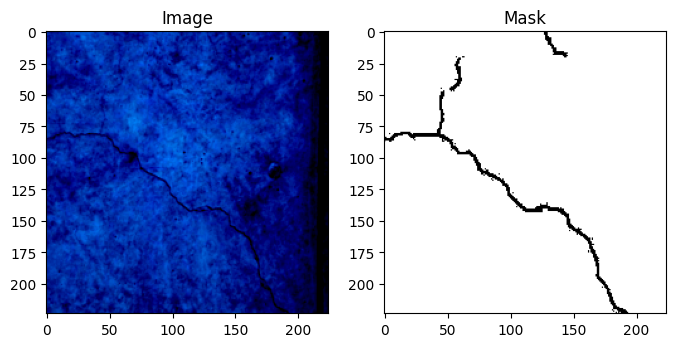

In [12]:
#Check image and mask
id = 10
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(train_dataset[id][0].permute(1, 2, 0));ax[0].set_title("Image")
ax[1].imshow(train_dataset[id][1][0],'binary');ax[1].set_title("Mask")
plt.show()

**Dataloader**

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([8, 3, 224, 224]) torch.Size([8, 1, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


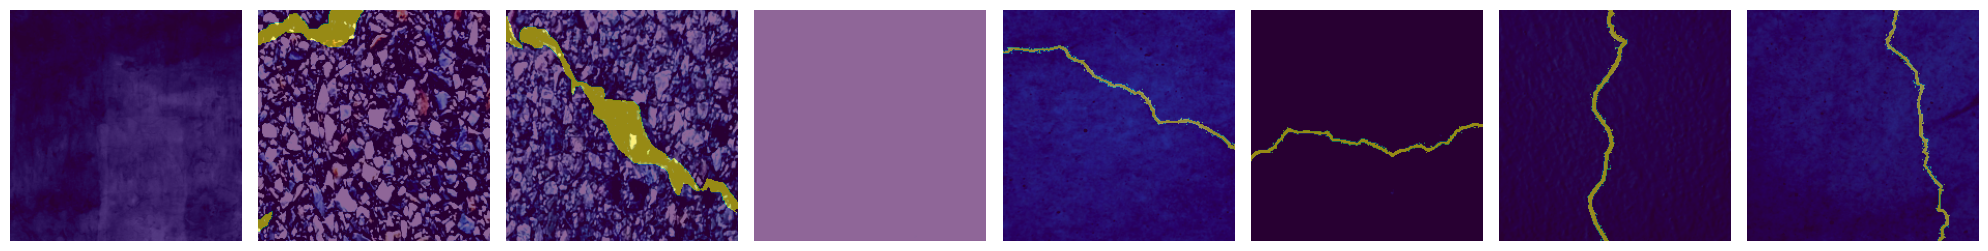

In [15]:
imgs, masks = next(iter(train_loader))
#print(masks)
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...][0].numpy()
        #print(masks==1)
        plt.imshow(img)
        plt.imshow(mask, alpha=0.6)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)

**Model**

**Creating model**

In [16]:
from modelUnet import UNET
model = UNET(3,16, 2)
model.to(device)
print(model)

UNET(
  (first_conv): Double_Conv(
    (double_conv): Sequential(
      (0): Conv_3_k(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv_3_k(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): Down_Conv(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Double_Conv(
        (double_conv): Sequential(
          (0): Conv_3_k(
            (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv_3_k(
            (conv1

**Training**

In [17]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou    

In [18]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()
val_losses = []
train_losses = []

train_accs = []
val_accs = []

train_iou = []
val_iou = []

In [19]:
def train(dataloader, model, loss_function, optimizer, epoch, store_every=9):
    train_correct_num, train_total, train_cost_acum = 0, 0, 0.0
    intersection, union = 0, 0
    model.train()
    for batch, (x,y) in enumerate(dataloader):
        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long).squeeze(1)
        #print(x.shape)
        scores = model(x)
        cost = loss_function(input=scores, target=y)
        #cost.requires_grad = True


        #Backpropagation
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        train_predictions = torch.argmax(scores, dim=1)
        train_correct_num += (train_predictions == y).sum()
        train_total += torch.numel(train_predictions)#total numero de elementos de train_predictions, if size=[a,b,c ] returns a*b*c
        train_cost_acum += cost
        
        #IOU
        intersection += (train_predictions*y).sum()
        union += (train_predictions + y - train_predictions*y).sum()
 
        if batch % store_every == 1:#1 cuz division by zero
            train_acc = float(train_correct_num)/train_total#el train total ya considera el batch
            train_cost_every = float(train_cost_acum)/batch#Se divide entre el batch, xq por cada batch se aumenta el loss
            iou_every = ((intersection)/(union + 1e-8)).item()
            writer.add_scalar('training loss',
                            train_cost_every,
                            epoch * len(dataloader) + batch)#len(dataloader) returns total number of batchs in an epoch
            writer.add_scalar('training accuracy',
                            train_acc,
                            epoch * len(dataloader) + batch)
            writer.add_scalar('training IOU',
                            iou_every,
                            epoch * len(dataloader) + batch)
            
            print("loss: ", train_cost_every, "Accuracy: ", train_acc, "IOU: ", iou_every)
            train_losses.append(train_cost_every)
            train_accs.append(train_acc)
            train_iou.append(iou_every)

In [20]:
def val(dataloader, model, loss_function,epoch):
    num_batches = len(dataloader)
    model.eval()
    val_loss, val_correct_num, val_total = 0.0, 0, 0
    intersection, union = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            pred = model(x)
            loss = loss_function(input=pred, target=y)
            
            val_loss += loss.item()
            val_predictions = torch.argmax(pred, dim=1)
            val_correct_num += ((val_predictions == y).sum()).item()
            val_total += torch.numel(val_predictions)

            #IOU
            intersection += (val_predictions*y).sum()
            union += (val_predictions + y - val_predictions*y).sum()

    val_loss /= num_batches
    val_correct_num = val_correct_num/val_total
    IOU = ((intersection)/(union + 1e-8)).item()
    writer.add_scalar('validation loss',
                    val_loss,epoch)
    writer.add_scalar('validation accuracy',
                    val_correct_num,epoch)
    writer.add_scalar('validation IOU',
                    IOU,epoch)
    print(f"Validation Error: \n Accuracy: {(100*val_correct_num):>0.1f}%, Avg loss: {val_loss:>8f}, IOU: {IOU:>0.3f} \n")
    val_losses.append(val_loss)
    val_accs.append(val_correct_num)
    val_iou.append(IOU)

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()#Hace el softmax y la funcion costo al mismo tiempo
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer, epoch)
    val(val_loader, model, loss_fn, epoch)
writer.close()

Epoch 1
-------------------------------
loss:  1.0845247507095337 Accuracy:  0.7493796835140306 IOU:  0.03793703764677048
loss:  0.2178861141204834 Accuracy:  0.9345614799541976 IOU:  0.02672487311065197
loss:  0.187527292653134 Accuracy:  0.9494674994021046 IOU:  0.0191819965839386
loss:  0.17435501302991593 Accuracy:  0.9534829641042839 IOU:  0.014440394006669521
loss:  0.16775896742537216 Accuracy:  0.9552515933388158 IOU:  0.011490157805383205
loss:  0.15805262068043585 Accuracy:  0.9579085342996906 IOU:  0.009892286732792854
loss:  0.1510668147693981 Accuracy:  0.9599978611003553 IOU:  0.008746207691729069
loss:  0.147105872631073 Accuracy:  0.9610304037480377 IOU:  0.00774267828091979
loss:  0.1421617481806507 Accuracy:  0.9625501343379412 IOU:  0.007081702817231417
loss:  0.13932870074016293 Accuracy:  0.9635022371853486 IOU:  0.006482423283159733
loss:  0.13590963594206087 Accuracy:  0.9641961382888753 IOU:  0.005964722950011492
loss:  0.13255983352661133 Accuracy:  0.965187194

In [ ]:
from matplotlib import pyplot as plt
plt.plot([los for los in train_losses], label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show

In [ ]:
plt.plot(train_accs, label='train_acc')
plt.plot([ac.data.cpu() for ac in val_accs], label='val_acc')
plt.legend()
plt.show

In [25]:
torch.save(model.state_dict(), "UNET_Paper_10k_Images_97_Dictv2.pth")
torch.save(model, "UNET_Paper_10k_Images_97_DictCompletev2.pth")

torch.Size([8, 2, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


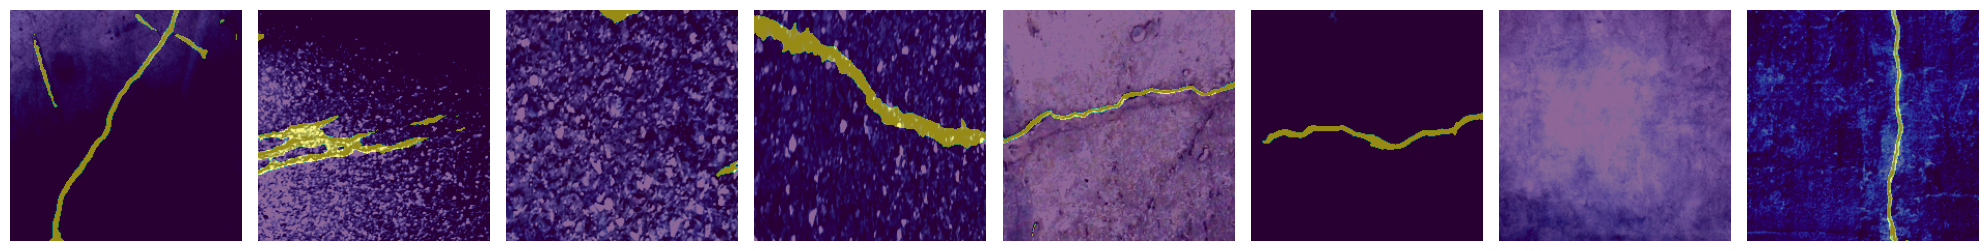

In [24]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
imgs_val, masks_val = next(iter(test_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    print(scores.shape)
    preds = torch.argmax(scores, dim=1).float()
    print(preds==1)
imgs_val = imgs_val.cpu()
preds = preds.cpu()
#print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

In [ ]:
import segmentation_models_pytorch as smp
import torch
# Cargar el modelo entrenado
from modelUnet import UNET
model_read = UNET(3,16, 2)
model_read.load_state_dict(torch.load('UNET_Paper_10k_Images_97_Dict.pth'))

# Establecer el modelo en modo de evaluación
model_read.eval()


imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model_read = model_read.to(device)
with torch.no_grad():
    scores = model_read(imgs_val)
    #print(scores.shape)
    preds = torch.argmax(scores, dim=1).float()
    #print(preds==1)
imgs_val = imgs_val.cpu()
preds = preds.cpu()
#print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))